In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from pylab import rcParams
rcParams['pdf.fonttype'] = 42

In [2]:
import numpy as np

## Example1: Plot ideogram

An ideogram file can be downloaded from the UCSC browser
- hg38: <http://hgdownload.cse.ucsc.edu/goldenpath/hg38/database/cytoBandIdeo.txt.gz>
- mm10: <http://hgdownload.cse.ucsc.edu/goldenpath/mm10/database/cytoBandIdeo.txt.gz>
- ...

You can download the cytoband file using `wget`. No need to uncompress because the plotting library can read both raw and gzip-ed files.

```bash
wget http://hgdownload.cse.ucsc.edu/goldenpath/hg38/database/cytoBandIdeo.txt.gz
```

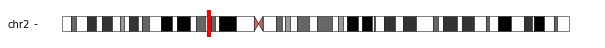

In [3]:
from genome_tools import plotting

fig,ax=plt.subplots()

plotting.ideogram("/home/jvierstra/cytoBandIdeo.txt.gz").render(ax, "chr2", 70000000)

fig.set_size_inches(10, 0.5)

## Example 2: Plot motif logo

There are 3 options for plotting motif logos: 
1. default SELEX-style where each position is scaled to one
2. information content that displays the relative information per nucleotide
3. an affinity logo (pioneered by Harmen Bussemaker)

The affinity logos are recommended to show how nucleotide polymorphisms are expected to alter the affinity of the TF to the sequence.

The `rc` argument is used to reverse complement the motif.

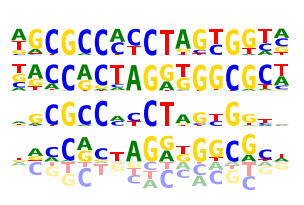

In [4]:
fig=plt.figure()

#You must set the figure size first, otherwise it will not render PWM properly
fig.set_size_inches(5, 3)

gs=gridspec.GridSpec(4, 1, height_ratios=[1,1,1,2])

mat=np.loadtxt("/home/jvierstra/data/motifs/moods/GRCh38_no_alts.alldbs.1e-4/pfm/CTCF_C2H2_1.pfm")

# default
ax=fig.add_subplot(gs[0,0])
plotting.pwm(mat).render(fig, ax, type='def')

# reverse-complement
ax=fig.add_subplot(gs[1,0])
plotting.pwm(mat).render(fig, ax, type='def', rc=True)

# bit-score style
ax=fig.add_subplot(gs[2,0])
plotting.pwm(mat).render(fig, ax, type='ic')

# affinity style
ax=fig.add_subplot(gs[3,0])
plotting.pwm(mat).render(fig, ax, type='affinity', rc=True)

## Example 3: Plot regions of the genome


#### Define a region of the genome using the `genomic_interval` class

In [5]:
from genome_tools import genomic_interval
interval=genomic_interval("chr19", 48363826, 48364602)

#### Load DNase I data directly from BAM-formated sequence alignment file

To run this example you need to install the python package <http://www.github.com/jvierstra/footprint-tools>.

In [6]:
from footprint_tools import cutcounts

data=cutcounts.bamfile("/net/seq/data/data-release/encode3/pipeline/human-encode2-GRCh38/alignments_full/hTR-DS14702.GRCh38.bam")
cuts=data[interval.widen(1)]
summed_cuts=(cuts['+'][1:] + cuts['-'][:-1])[:-1]

assert(len(summed_cuts)==len(interval))


#### Render the data

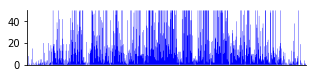

In [7]:
from genome_tools.plotting import continuous_data_track

fig,ax=plt.subplots()
fig.set_size_inches(5, 1)

track=continuous_data_track(interval, summed_cuts, fill_between=0, min=0, max=50)
track.render(ax)

## Example 4: Plot gene annotation track and data

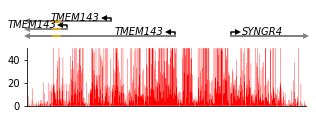

In [8]:
from genome_tools.plotting import gencode_annotation_track

fig=plt.figure()
fig.set_size_inches(5, 1.75)

gs=gridspec.GridSpec(2, 1, height_ratios=[0.5, 1])

ax=fig.add_subplot(gs[0,0])
track=gencode_annotation_track(interval)
track.load_data("/home/jvierstra/data/genomes/hg38/gencode.v25.chr_patch_hapl_scaff.basic.annotation.gff3.gz")
track.render(ax)

ax=fig.add_subplot(gs[1,0])
track=continuous_data_track(interval, summed_cuts, fill_between=0, min=0, max=50, facecolor="red")
track.render(ax)

## Example 5: Plot chromsome, ideogram, gene annotation and data

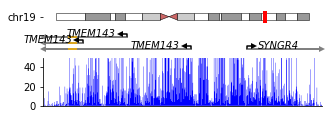

In [9]:
from genome_tools.plotting import gencode_annotation_track

fig=plt.figure()
fig.set_size_inches(5, 1.75)

gs=gridspec.GridSpec(3, 1, height_ratios=[0.25, 0.5, 1])

# Chromosome ideogram
ax=fig.add_subplot(gs[0,0])
plotting.ideogram().render(ax, interval.chrom, interval.start)

# GENCODE gene annotation track
ax=fig.add_subplot(gs[1,0])
track=gencode_annotation_track(interval)
track.load_data("/home/jvierstra/data/genomes/hg38/gencode.v25.chr_patch_hapl_scaff.basic.annotation.gff3.gz")
track.render(ax)

# DNase I per-nucleotide cleavage data
ax=fig.add_subplot(gs[2,0])
track=continuous_data_track(interval, summed_cuts, fill_between=0, min=0, max=50)
track.render(ax)

## Example 6: Plot large regions using density smoothing

In [10]:
interval_lg = interval.widen(50000)

cuts_lg=data[interval_lg.widen(1)]
summed_cuts_lg=(cuts_lg['+'][1:] + cuts_lg['-'][:-1])[:-1]

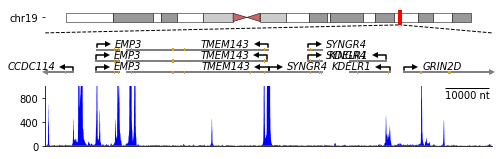

In [11]:
from genome_tools.plotting import gencode_annotation_track
from genome_tools.plotting import connectors

fig=plt.figure()
fig.set_size_inches(8, 2.5)

gs=gridspec.GridSpec(3, 1, height_ratios=[0.25, 0.75, 1])

# Chromosome ideogram
ax_ideogram=fig.add_subplot(gs[0,0])
plotting.ideogram().render(ax_ideogram, interval_lg.chrom, interval_lg.start)

# GENCODE gene annotation track
ax_gencode=fig.add_subplot(gs[1,0])
track=gencode_annotation_track(interval_lg)
track.load_data("/home/jvierstra/data/genomes/hg38/gencode.v25.chr_patch_hapl_scaff.basic.annotation.gff3.gz")
track.render(ax_gencode)

# DNase I per-nucleotide cleavage data
ax=fig.add_subplot(gs[2,0])
track=continuous_data_track(interval_lg, summed_cuts_lg, density=True, fill_between=0, min=0, max=1000, scale_bar=10000)
track.render(ax)


#call-out zoom effect between ideogram and gene annotation track
c1, c2, b1,b2, p = connectors.zoom_effect(ax_gencode, ax_ideogram, ls='--', facecolor='none')

## Example 7: Multi-tiered plotting

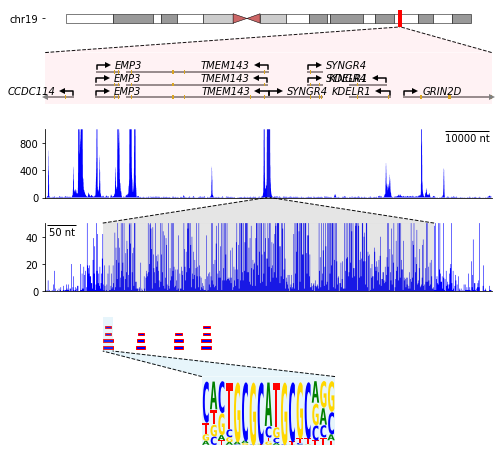

In [15]:
from genome_tools.plotting import gencode_annotation_track
from genome_tools.plotting import segment_track
from genome_tools.plotting import connectors

fig=plt.figure()
fig.set_size_inches(8, 8)

gs=gridspec.GridSpec(6, 1, height_ratios=[0.25, 0.75, 1, 1, 0.5, 1], hspace=0.5)

# Chromosome ideogram
ax_ideogram=fig.add_subplot(gs[0,0])
plotting.ideogram().render(ax_ideogram, interval_lg.chrom, interval_lg.start)

# GENCODE gene annotation track
ax_gencode=fig.add_subplot(gs[1,0])
track=gencode_annotation_track(interval_lg)
track.load_data("/home/jvierstra/data/genomes/hg38/gencode.v25.chr_patch_hapl_scaff.basic.annotation.gff3.gz")
track.render(ax_gencode)

# DNase I per-nucleotide cleavage data
ax_lg=fig.add_subplot(gs[2,0])
track=continuous_data_track(interval_lg, summed_cuts_lg, density=True, fill_between=0, min=0, max=1000, scale_bar=10000)
track.render(ax_lg)

#call-out zoom effect between ideogram and gene annotation track
c1, c2, b1,b2, p = connectors.zoom_effect(ax_gencode, ax_ideogram, ls='--', facecolor='pink')

#add a zoomed in track
ax_zoom=fig.add_subplot(gs[3,0])
track=continuous_data_track(interval, summed_cuts, fill_between=0, min=0, max=50, scale_bar=50, scale_bar_loc=2)
track.render(ax_zoom)

# add the callout connector
c1, c2, b1,b2, p = \
    connectors.zoom_effect(ax_zoom, ax_lg, 
                           xlims=(interval.start+100, interval.end-100), 
                           ls='--', facecolor='grey')


ax_motifs=fig.add_subplot(gs[4,0])
track=segment_track(interval, edgecolor='red', lw=1)
# You can define your own filter function when reading in BED-style data
# variable "x" refers to an instance of a genomic_interval
filtfunc = lambda x: x.name.find("NRF1")>=0 and x.strand=='+'
track.load_data("/home/jvierstra/data/motifs/moods/GRCh38_no_alts.alldbs.1e-4/moods.combined.all.bed.gz", filterfunc=filtfunc)
track.render(ax_motifs)


#draw motif
ax=fig.add_subplot(gs[5,0])

motif=track.segments[1]

pfm_file="/home/jvierstra/data/motifs/moods/GRCh38_no_alts.alldbs.1e-4/pfm/" + motif.name +".pfm"
mat=np.loadtxt(pfm_file)

plotting.pwm(mat).render(fig, ax, type='def', xoffset=motif.start, pad=20)

# add the callout connector
c1, c2, b1,b2, p = \
    connectors.zoom_effect(ax, ax_motifs, xlims=(motif.start, motif.end),
                           ls='--', facecolor='skyblue')

##to save a pdf:
##plt.savefig("fig.pdf", transparent=True)
